In [172]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# PCA module
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.preprocessing import OneHotEncoder
import datetime

In [3]:
r_dir = r'../raw_data/'
c_dir = r'../cleaned_data/'

In [4]:
Features = pd.read_csv(c_dir+"TS_2018.csv")
Features['tpep_pickup_datetime'] = pd.to_datetime(Features['tpep_pickup_datetime'],format ='%Y-%m-%d %H:%M:%S')

In [5]:
Features.head()

,Unnamed: 0,tpep_pickup_datetime,DOM,DOW,HOD,bad_weather,is_holiday,lag1,lag2,lag3,...,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,trip_count
0,0,2018-09-02 00:00:00,2,6,0,0,0,480,672,398,...,150,115,80,76,166,156,181,282,441,351
1,1,2018-09-02 01:00:00,2,6,1,0,0,351,480,672,...,259,150,115,80,76,166,156,181,282,260
2,2,2018-09-02 02:00:00,2,6,2,0,0,260,351,480,...,341,259,150,115,80,76,166,156,181,173
3,3,2018-09-02 03:00:00,2,6,3,0,0,173,260,351,...,363,341,259,150,115,80,76,166,156,148
4,4,2018-09-02 04:00:00,2,6,4,0,0,148,173,260,...,358,363,341,259,150,115,80,76,166,154


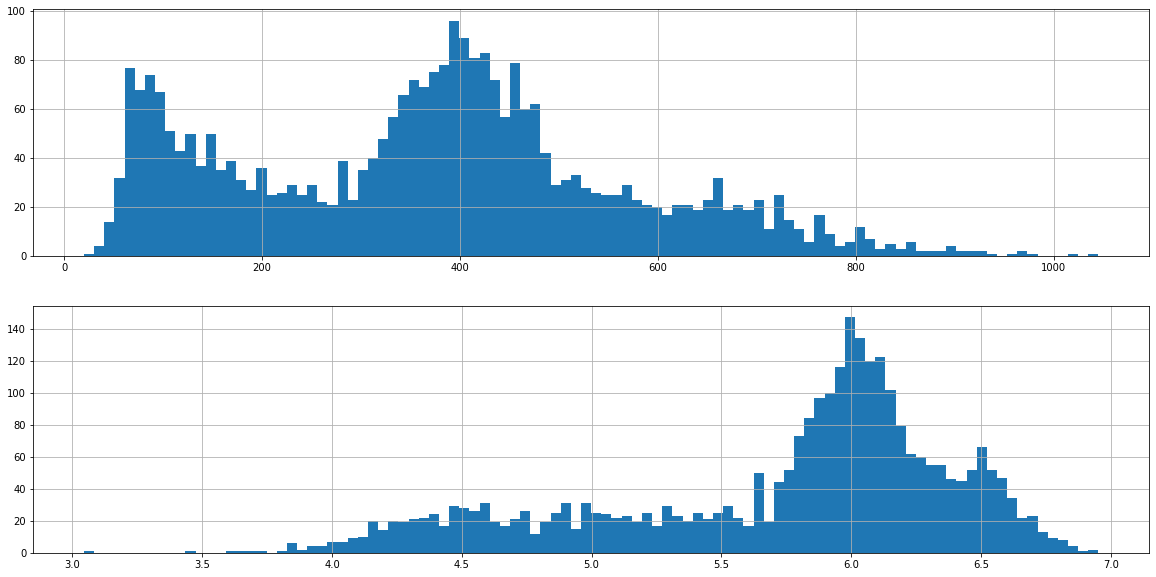

In [299]:
df = Features.copy()
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
df['trip_count'].hist(bins=100, ax=axes[0])
df['trip_count'] = np.log1p(df['trip_count'])
df['trip_count'].hist(bins=100, ax=axes[1])
plt.show()

In [ ]:
# Feature splitting with scaler encoding onl

In [261]:
test_df_s = Features.iloc[2160:,1:]
test_dfx_s = test_df_s.drop(['trip_count','tpep_pickup_datetime'],axis=1)
test_dfy_s = test_df_s.trip_count

train_df_s = Features.iloc[0:1728,1:]
train_dfx_s = train_df_s.drop(['trip_count','tpep_pickup_datetime'],axis=1)
train_dfy_s = train_df_s.trip_count

valid_df_s = Features.iloc[1728:2160,1:]
valid_dfx_s = valid_df_s.drop(['trip_count','tpep_pickup_datetime'],axis=1)
valid_dfy_s = valid_df_s.trip_count

train_opt_df_s = Features.iloc[0:2160:,1:]
train_opt_dfx_s = train_opt_df_s.drop(['trip_count','tpep_pickup_datetime'],axis=1)
train_opt_dfy_s = train_opt_df_s.trip_count

In [119]:
# One hot encoding 
cat_columns = ['DOW','DOM','HOD']
Features_onehot =  pd.get_dummies(Features,prefix_sep="__",columns=cat_columns)
Features_onehot.shape

(2904, 91)

In [262]:
# Train validation test split
test_df = Features_onehot.iloc[2160:,1:]
test_dfx = test_df.drop(['trip_count','tpep_pickup_datetime'],axis=1)
test_dfy = test_df.trip_count

train_df = Features_onehot.iloc[0:1728,1:]
train_dfx = train_df.drop(['trip_count','tpep_pickup_datetime'],axis=1)
train_dfy = train_df.trip_count

valid_df = Features_onehot.iloc[1728:2160,1:]
valid_dfx = valid_df.drop(['trip_count','tpep_pickup_datetime'],axis=1)
valid_dfy = valid_df.trip_count

train_opt_df = Features_onehot.iloc[0:2160:,1:]
train_opt_dfx = train_opt_df.drop(['trip_count','tpep_pickup_datetime'],axis=1)
train_opt_dfy = train_opt_df.trip_count

In [100]:
#train_X = np.array(train_X)
#train_y = np.array(train_dfy)

#test_X = np.array(test_X)
#test_y = np.array(test_dfy)

#valid_X = np.array(valid_X)
#valid_y = np.array(valid_dfy)

# Persistence model baseline

In [295]:
# walk-forward validation
predictions = test_df.lag1
test_score = np.sqrt(mean_squared_error(predictions, test_df.trip_count))
print('Test RMSE for baseline is : %.3f' % test_score)

Test RMSE for baseline is : 91.277


In [ ]:
#  time difference data

# linear regression

In [144]:
reg = LinearRegression().fit(train_dfx,train_dfy)

In [145]:
print('in_sample R2',reg.score(train_dfx,train_dfy))
print('Out_sample R2',reg.score(valid_dfx,valid_dfy))
print('train RMSE',mean_squared_error())
print('Validation RMSE')

in_sample R2 0.9270411500120228
Out_sample R2 0.8908592154193544


In [134]:
# regularization not very useful in this case
reg_lasso =  linear_model.Lasso(alpha=0.1).fit(train_dfx,train_dfy)
print('in_sample R2',reg_lasso.score(train_dfx,train_dfy))
print('Out_sample R2',reg_lasso.score(valid_dfx,valid_dfy))

in_sample R2 0.9255560955016525
Out_sample R2 0.8980644517527195


In [ ]:
# Detrending + Log transformation

In [256]:
# Linear Regression
lm_train = smf.ols(formula = 'trip_count ~ C(bad_weather)+C(is_holiday)+'+'+'.join(train_dfx.columns[2:88]), data = train_df).fit()
lm_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             trip_count   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     243.8
Date:                Fri, 13 Dec 2019   Prob (F-statistic):               0.00
Time:                        21:48:48   Log-Likelihood:                -9324.7
No. Observations:                1728   AIC:                         1.882e+04
Df Residuals:                    1642   BIC:                         1.929e+04
Df Model:                          85                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              66.1698     17.067      3.877      0.000      32.694      99.645
C(bad_weather)[T.1]    17.8829     14.947      1.196      0.232     -11.435      47.201
C(is_holiday)[T.1]     -7.8743      8.046     -0.979      0.328     -23.656       7.907
lag1                    0.6415      0.024     26.551      0.000       0.594       0.689
lag2                   -0.0364      0.029     -1.258      0.208      -0.093       0.020
lag3                    0.0998      0.029      3.458      0.001       0.043       0.156
lag4                    0.0036      0.029      0.125      0.901      -0.053       0.061
lag5                   -0.0355      0.029     -1.227      0.220      -0.092       0.021
lag6                    0.0503      0.029      1.744      0.081      -0.006       0.107
lag7                   -0.1137      0.029     -3.937      0.000      -0.170      -0.057
lag8                    0.0394      0.029      1.363      0.173      -0.017       0.096
lag9                    0.0041      0.029      0.142      0.887      -0.053       0.061
lag10                   0.0308      0.029      1.065      0.287      -0.026       0.088
lag11                   0.0478      0.029      1.653      0.099      -0.009       0.104
lag12                   0.0258      0.029      0.893      0.372      -0.031       0.083
lag13                  -0.0263      0.029     -0.911      0.362      -0.083       0.030
lag14                  -0.0782      0.029     -2.707      0.007      -0.135      -0.022
lag15                   0.0412      0.029      1.424      0.155      -0.016       0.098
lag16                   0.0157      0.029      0.541      0.589      -0.041       0.072
lag17                  -0.0283      0.029     -0.977      0.329      -0.085       0.029
lag18                   0.0562      0.029      1.951      0.051      -0.000       0.113
lag19                  -0.1247      0.029     -4.319      0.000      -0.181      -0.068
lag20                  -0.0168      0.029     -0.578      0.563      -0.074       0.040
lag21                  -0.0370      0.029     -1.277      0.202      -0.094       0.020
lag22                   0.0046      0.029      0.158      0.875      -0.052       0.061
lag23                   0.0407      0.029      1.406      0.160      -0.016       0.097
lag24                   0.1819      0.024      7.583      0.000       0.135       0.229
DOW__0                 10.7025      5.037      2.125      0.034       0.823      20.583
DOW__1                 21.9602      4.830      4.547      0.000      12.487      31.433
DOW__2                 19.0643      6.206      3.072      0.002       6.891      31.237
DOW__3                 16.3809      5.981      2.739      0.006       4.649      28.113
DOW__4                  7.2193      5.990      1.205      0.228      -4.530      18.969
DOW

In [257]:
lmy = lm_train.predict(valid_df)
R2_OS = r2_score(valid_df.trip_count,lmy)
MAE = mean_absolute_error(valid_df.trip_count,lmy)
RMSE = np.sqrt(mean_squared_error(valid_df.trip_count,lmy))
print('The validation sample R2 is',R2_OS)
print('The validation mean absolute error is',MAE)
print('The validation RMSE is',RMSE)

The validation sample R2 is 0.8973529723048397
The validation mean absolute error is 46.736261228038934
The validation RMSE is 67.39476324941478


In [258]:
lmy_t = lm_train.predict(test_df)
R2_OS = r2_score(test_df.trip_count,lmy_t)
MAE = mean_absolute_error(test_df.trip_count,lmy_t)
RMSE = np.sqrt(mean_squared_error(test_df.trip_count,lmy_t))
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)
print('The test RMSE is',RMSE)

The test sample R2 is 0.8892783702183525
The test mean absolute error is 45.296539039611936
The test RMSE is 62.30184534641106


# Linear Regression Optimal

In [263]:
# retrain on all data
reg = LinearRegression().fit(train_opt_dfx,train_opt_dfy)
lmy_t = reg.predict(test_dfx)
R2_OS = r2_score(test_dfy,lmy_t)
MAE = mean_absolute_error(test_dfy,lmy_t)
RMSE = np.sqrt(mean_squared_error(test_dfy,lmy_t))
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)
print('The test RMSE is',RMSE)

The test sample R2 is 0.8913862318550416
The test mean absolute error is 44.65858270788706
The test RMSE is 61.70596038124052


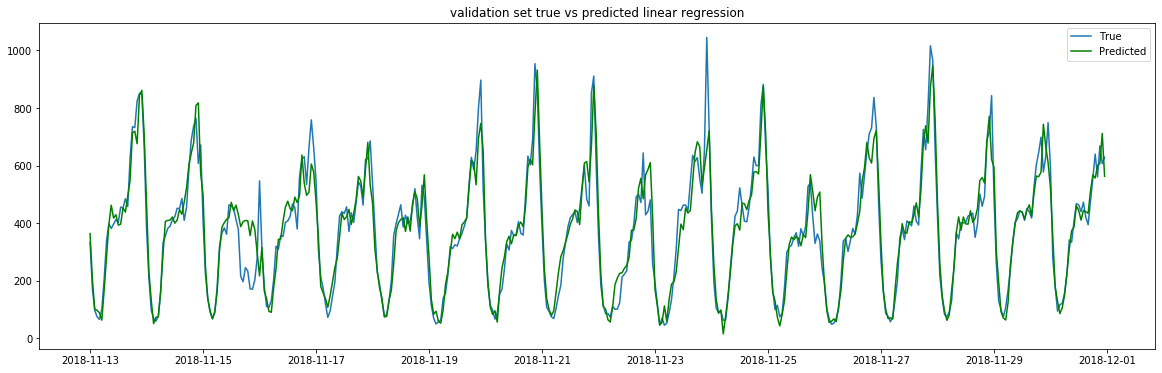

In [150]:
plt.figure(figsize=(20,6))
plt.plot(valid_df['tpep_pickup_datetime'],valid_df['trip_count'],label='True')
plt.plot(valid_df['tpep_pickup_datetime'],lmy, color='green',label='Predicted')
plt.title('validation set true vs predicted linear regression')
plt.legend()
plt.show()

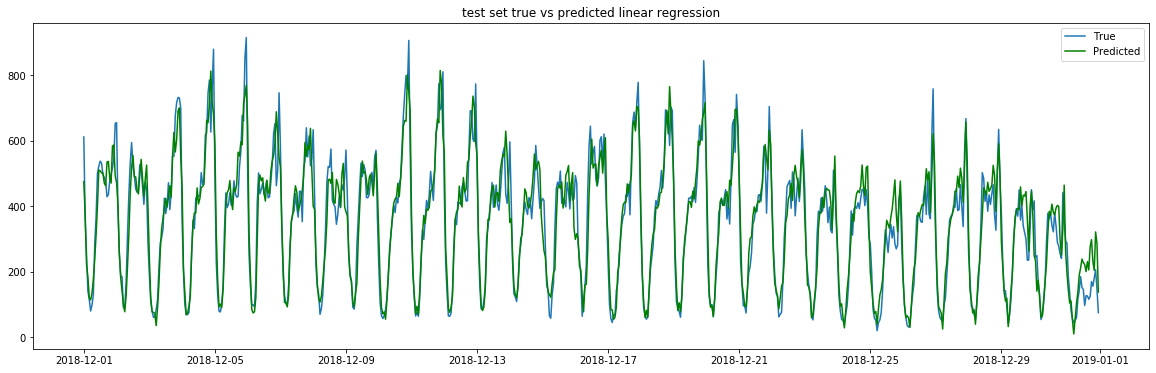

In [154]:
plt.figure(figsize=(20,6))
plt.plot(test_df['tpep_pickup_datetime'],test_df['trip_count'],label='True')
plt.plot(test_df['tpep_pickup_datetime'],lmy_t, color='green',label='Predicted')
plt.title('test set true vs predicted linear regression')
plt.legend()
plt.show()

In [ ]:
# Different splits: Train test, Multiple Train test , Walk forward Validation

# Random Forest

In [260]:
# Random Forest could handle scaler encoded data directly 
regrf = RandomForestRegressor(n_estimators=100,max_depth=30, max_features=16, bootstrap=True,oob_score=True).fit(train_dfx_s,train_dfy_s)
train_predict = regrf.predict(train_dfx_s)
valid_predict = regrf.predict(valid_dfx_s)
test_predict = regrf.predict(test_dfx_s)

Train_RMSE = np.sqrt(mean_squared_error(train_predict,train_dfy_s))
Valid_RMSE = np.sqrt(mean_squared_error(valid_predict,valid_dfy_s))   
Test_RMSE = np.sqrt(mean_squared_error(test_predict,test_dfy_s))

print('in_sample R2',regrf.score(train_dfx_s,train_dfy_s))
print('Out_sample R2',regrf.score(valid_dfx_s,valid_dfy_s))
print('train RMSE',Train_RMSE)
print('Validation RMSE',Valid_RMSE)
print('Validation RMSE',Test_RMSE)

in_sample R2 0.9912865258926263
Out_sample R2 0.8842639756193437
train RMSE 18.385542695507613
Validation RMSE 71.56278652861933
Validation RMSE 62.13279838984148


In [ ]:
# Random Forest parameter tuning number of trees and maximum number of features to find lowest validation RMSE
# test number of tree from 100 to 500 with step 10
# test max features from 10 to 29
n_tree=[int(i) for i in range(100,501,10)]
max_features=[int(i) for i in range(10,30)]
optimal_param = np.zeros(2)
valid_RMSE_list = []
min_RMSE = 1000

for j in max_features:
    for i in n_tree:
        regr=RandomForestRegressor(n_estimators=i,max_features=j,bootstrap=True,oob_score=True,n_jobs=-1)
        regr.fit(train_dfx_s,train_dfy_s) 
        valid_predict = regr.predict(valid_dfx_s)
        valid_RMSE = np.sqrt(mean_squared_error(valid_predict,valid_dfy_s))
        valid_RMSE_list.append(valid_RMSE)
        if valid_RMSE < min_RMSE:
            min_RMSE = valid_RMSE
            optimal_param[0] = j
            optimal_param[1] = i
        if i%20==0:
            print(j,'and',i,'epochs')

In [213]:
print('lowest valid RMSE is',min_RMSE,'with max_features',optimal_param[0],'and n_tress',optimal_param[1])

lowest valid RMSE is 70.05558346274447 with max_features 16.0 and n_tress 100.0


# Random Forest Optimal

In [281]:
# retrain on all train and validation
reg = RandomForestRegressor(n_estimators=100, max_features=16, bootstrap=True,oob_score=True).fit(train_opt_dfx_s,train_opt_dfy_s)
lmy_t = reg.predict(test_dfx_s)
R2_OS = r2_score(test_dfy_s,lmy_t)
MAE = mean_absolute_error(test_dfy_s,lmy_t)
RMSE = np.sqrt(mean_squared_error(test_dfy_s,lmy_t))
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)
print('The test RMSE is',RMSE)

The test sample R2 is 0.896588513248471
The test mean absolute error is 43.05782258064516
The test RMSE is 60.21006090686674


# Xgboost

In [292]:
# Xgboost

xgb_model = xgb.XGBRegressor(n_estimators=500,max_depth = 5).fit(train_dfx_s,train_dfy_s)
Xgboost_train_predict = xgb_model.predict(train_dfx_s)
Xgboost_valid_predict = xgb_model.predict(valid_dfx_s)

Train_RMSE = np.sqrt(mean_squared_error(train_dfy_s, Xgboost_train_predict))
Valid_RMSE = np.sqrt(mean_squared_error(valid_dfy_s, Xgboost_valid_predict) )   
            
print('in_sample R2',r2_score(train_dfy_s, Xgboost_train_predict))
print('Out_sample R2',r2_score(valid_dfy_s, Xgboost_valid_predict))
print('train RMSE',Train_RMSE)
print('Validation RMSE',Valid_RMSE)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[23:11:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
in_sample R2 0.9994504099087894
Out_sample R2 0.9014909885027181
train RMSE 4.617429021102013
Validation RMSE 66.02234466628659


In [ ]:
n_tree=[int(i) for i in range(100,501,50)]
max_depth=[int(i) for i in range(5,11)]
optimal_param_xgb = np.zeros(3)
valid_RMSE_list_xgb = []
min_RMSE_xgb = 1000

for i in max_depth:
    for j in n_tree:
        for k in learning_rate:
            regr=xgb.XGBRegressor(n_estimators=j,max_depth=i,learning_rate = k, n_jobs=-1)
            regr.fit(train_dfx_s,train_dfy_s) 
            valid_predict = regr.predict(valid_dfx_s)
            valid_RMSE = np.sqrt(mean_squared_error(valid_predict,valid_dfy_s))
            valid_RMSE_list_xgb.append(valid_RMSE)
            if valid_RMSE < min_RMSE_xgb:
                min_RMSE_xgb = valid_RMSE
                optimal_param_xgb[0] = i
                optimal_param_xgb[1] = j
                optimal_param_xgb[2] = k
            print(j,'and',i,'epochs')

In [249]:
print('lowest valid RMSE is',min_RMSE_xgb ,'with max_depth',optimal_param_xgb[0],'n_estimators',optimal_param_xgb[1],'and learning rate',optimal_param_xgb[2])

lowest valid RMSE is 64.86716820856458 with max_depth 7.0 n_estimators 300.0 and learning rate 0.1


# Xgboost Optimal 

In [286]:
# retrain on all data
xgb_model=xgb.XGBRegressor(n_estimators=1000,max_depth=8,learning_rate = 0.1, n_jobs=-1)
xgb_model.fit(train_opt_dfx_s,train_opt_dfy_s) 
test_predict = xgb_model.predict(test_dfx_s)

R2_OS = r2_score(test_dfy_s,test_predict)
MAE = mean_absolute_error(test_dfy_s,test_predict)
RMSE = np.sqrt(mean_squared_error(test_dfy_s,test_predict))
print('The test sample R2 is',R2_OS)
print('The test mean absolute error is',MAE)
print('The test RMSE is',RMSE)

/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Applications/anaconda3/envs/py3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[22:51:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The test sample R2 is 0.8942852104244643
The test mean absolute error is 43.54332479866602
The test RMSE is 60.87690299247398


In [ ]:
# LSTM
